In [1]:
import math 
import numpy as np
import random
import matplotlib.pyplot as plt
from graphviz import Digraph

In [2]:
def f(x):
    return x**2-2*x+21

In [3]:
f(10)

101

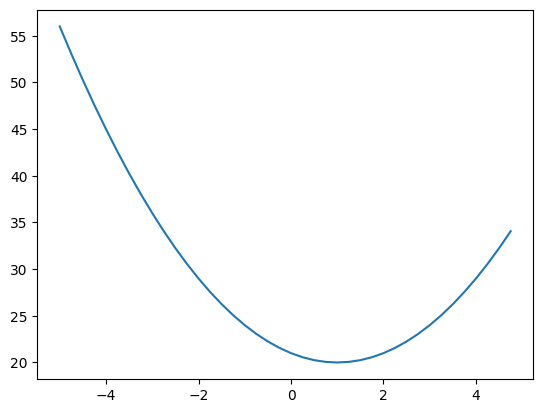

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.00000001
x = 1
(f(x + h) - f(x))/h

0.0

In [6]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data;
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None
        self.grad = 0.0

    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward(): 
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other):
        return self + other
        

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self, other): 
        return self * other

    def __truediv__(self, other):   
        # here, we call pow before multiplying. For now, by default are considering pow to be a function that raises the variable `self` 
        # to some power. So it is considered a constant here, and never taken as a Value or differentiated. 
        return self * other**(-1)

    def __pow__(self, other): 
        assert isinstance(other, (int, float)), "only int and float supported for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * ( self.data ** (other - 1 )) * out.grad
        out._backward = _backward

        return out
    
    def __sub__(self, other): 
        return self + (-other)

    def exp(self): 
        x = self.data 
        out = Value(math.exp(x), (self, ), "e")
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out 

    def tanh(self):
        x = self.data
        t = (math.exp(2.0 * x) - 1)/(math.exp(2.0 * x) + 1)
        out = Value(t, (self,), "tanh")
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(o):
            if o not in visited: 
                visited.add(o)
                for child in o._prev:
                    build_topo(child) 
                topo.append(o)
                
        build_topo(self)

        for node in reversed(topo):
            node._backward()

        

In [7]:
def printFamily(root, m):
    indentString = "  "
    print(indentString * m,root._prev, root._op) 
    for child in root._prev:
        print(indentString * (m+1), child)
        if child._prev: 
            printFamily(child, m+1)

In [8]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [9]:
# this actually works well for our case, in fact does the same thing as the topological sort. But might go over the same element 
# multiple times, which isn't possible in topo sort. So, it's less efficient, but works. 
def traverse_backward(o): 
    o._backward() 
    for child in o._prev:
        traverse_backward(child)
        
traverse_backward(o)

NameError: name 'o' is not defined

In [10]:
class Neuron: 
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x): 
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self): 
        return self.w + [self.b]


class Layer: 
    def __init__(self, nin, nout): 
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x): 
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self): 
        return [p for n in self.neurons for p in n.parameters()] 

class MLP: 
    def __init__(self, nin, nouts): 
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

    def __call__(self, x):
        for layer in self.layers: 
            x = layer(x)
        return x

In [11]:
xs = [
    [1.0, -3.0, 4.0],
    [2.0, 2.0, -1.0],
    [2.5, -2.5, 1.5],
    [2.0, 3.0, 1.0],
]

ys = [-1.0, -1.0, 1.0, 1.0]

nn = MLP(4, [10, 10, 10, 1])

In [12]:
for k in range(20): 
    ypred1 = [nn(x) for x in xs]
    loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
    loss.grad = 1

    for p in nn.parameters(): 
        p.grad = 0

    loss.backward()

    for p in nn.parameters():
        p.data += -0.09 * p.grad

    print(k, loss)

NameError: name 'ypred' is not defined

In [13]:
ypred 
# took me 5 iterations i.e, 100 steps

NameError: name 'ypred' is not defined

In [14]:
l = 10
e = 4.0
gradVector = [0.0 for _ in nn.parameters()]

In [15]:
for k in range(20): 
    ypred = [nn(x) for x in xs]
    loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
    loss.grad = 1

    for p in nn.parameters(): 
        p.grad = 0

    loss.backward()


    # Adagrad: for each weight: l = l_initial/mag([grad vector])
    for i, p in enumerate(nn.parameters()):
        gradVector[i] = math.sqrt(gradVector[i]**2 + p.grad**2)
        
        p.data += -(l/(gradVector[i] + e)) * p.grad

    print(k, loss)

0 Value(data=7.551985290191932)
1 Value(data=7.972523476207925)
2 Value(data=6.508426277342792)
3 Value(data=7.999999999999998)
4 Value(data=7.999999999999998)
5 Value(data=7.999999999999998)
6 Value(data=7.999999999999998)
7 Value(data=7.999999999999998)
8 Value(data=7.999999999999998)
9 Value(data=7.999999999999998)
10 Value(data=7.999999999999998)
11 Value(data=7.999999999999998)
12 Value(data=7.999999999999998)
13 Value(data=7.999999999999998)
14 Value(data=7.999999999999998)
15 Value(data=7.999999999999998)
16 Value(data=7.999999999999998)
17 Value(data=7.999999999999998)
18 Value(data=7.999999999999998)
19 Value(data=7.999999999999998)


In [290]:
[round(yp.data) for yp in ypred] 
# took me only 2 iterations

[-1, -1, 1, 1]